In [1]:
#!pip install tensorflow-probability[tf]
BATCH = 5

### Librerias

In [2]:
from keras import backend as K
import numpy as np
import cv2
from PIL import Image, ImageEnhance ,ImageFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
#-----------------
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

2024-10-29 00:17:00.689665: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 00:17:01.115321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730157421.256622    3815 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730157421.295399    3815 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 00:17:01.700417: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
ds = tfp.distributions
import logging
import warnings
warnings.filterwarnings("ignore")

# Verificar dispositivos disponibles
if tf.test.gpu_device_name():
    print('GPU encontrada:', tf.test.gpu_device_name())
else:
    print("No se encontró GPU. Se utilizará la CPU.")

# Listar todas las GPU disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')

# Configurar el crecimiento de memoria para cada GPU
if gpus:
    for gpu in gpus:
        print("Activada la asignacion de memoria gradual")
        tf.config.experimental.set_memory_growth(gpu, True)

No se encontró GPU. Se utilizará la CPU.


W0000 00:00:1730157440.910418    3815 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
W0000 00:00:1730157440.982901    3815 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
print(tf.__version__, tfp.__version__)

2.18.0 0.24.0


In [5]:
import sqlite3
import shutil
import pandas as pd

 # Comprobar si el archivo existe
if not os.path.exists('../datos/grabacion/base_datos_cod_augmented.db'):
    # Copiar el archivo
    shutil.copy('../datos/grabacion/base_datos_cod.db', '../datos/grabacion/base_datos_cod_augmented.db')
    print("Archivo copiado exitosamente..")
else:
    print("Archivo ya existe..")

# Conectar a la base de datos (crea el archivo si no existe)
conexion = sqlite3.connect("../datos/grabacion/base_datos_cod_augmented.db")

# Crear un cursor para interactuar con la base de datos
cursor = conexion.cursor()

Archivo ya existe..


In [6]:
cursor.execute("SELECT MAX(id) FROM videos_mapa")
ID = cursor.fetchone()[0]

if ID == None:
    ID = 0

ID

2939

In [7]:
CANTIDAD_VIDEOS = 5

cursor.execute("SELECT id as id_video, COUNT(*) AS cantidad FROM videos_mapa GROUP BY id HAVING COUNT(*) > "+str(CANTIDAD_VIDEOS)+"")
resultados = cursor.fetchall()

# Obtener los nombres de las columnas
columnas = [descripcion[0] for descripcion in cursor.description]

# Crear el DataFrame
df_ids = pd.DataFrame(resultados, columns=columnas)

# Utilizando .to_numpy()
ARRAY_ID = df_ids['id_video'].to_numpy()

In [8]:
# Dividir en entrenamiento y prueba (10% para prueba)
X_train_Mapa, X_test_Mapa = train_test_split(ARRAY_ID, test_size=0.1, random_state=42)
# Dividir entrenamiento en entrenamiento y validación (30% de 90% para validación)
X_train_Mapa, X_valid_Mapa = train_test_split(X_train_Mapa, test_size=0.3, random_state=42)

In [9]:
print("train ->"+str(len(X_train_Mapa)))
print("valid ->"+str(len(X_valid_Mapa)))
print("test ->"+str(len(X_test_Mapa)))

train ->1417
valid ->608
test ->225


In [10]:
def crear_dataframe(lista_ids):
    # Crear un DataFrame vacío para almacenar los resultados
    df_mapa = pd.DataFrame()
    df_pov = pd.DataFrame()

    for id in lista_ids:
        query = f"SELECT * FROM videos_mapa WHERE id == {id}"
        query_pov = f"SELECT * FROM videos_pov WHERE id == {id}"

        # Leer el resultado de la consulta y añadirlo al DataFrame
        df_temporal = pd.read_sql_query(query, conexion)
        df_temporal_pov = pd.read_sql_query(query_pov, conexion)

        # Concatenar al DataFrame principal
        df_mapa = pd.concat([df_mapa, df_temporal], ignore_index=True)
        df_pov = pd.concat([df_pov, df_temporal_pov], ignore_index=True)
    
    return df_mapa , df_pov

In [11]:
df_train_mapa , df_train_pov = crear_dataframe(X_train_Mapa)
df_valid_mapa , df_valid_pov = crear_dataframe(X_valid_Mapa)
df_test_mapa , df_test_pov = crear_dataframe(X_test_Mapa)
conexion.close()

In [12]:
import ast

def preprocesado_df(df):
    # Convertir la columna de tipo object a listas de enteros
    df['etiqueta'] = df['etiqueta'].apply(ast.literal_eval)
    # Eliminamos las filas donde 'mouse_final' sea igual a [0, 4]
    filtro = df['etiqueta'].apply(lambda x: x[1] == 4)
    df = df[~filtro]
    # Crear un filtro booleano para las filas que cumplen la condición
    condicion = df['etiqueta'].apply(lambda x: x[1] == 2)
    # Juntamos las pulsaciones y tecla en una columna
    #x_positions_2 = df['etiqueta'].apply(lambda x: str(x[0])+str(x[1]))
    x_positions_2 = df['etiqueta'].apply(lambda x: str(x[1]))
    df['etiqueta'] = x_positions_2
    # Modificar solo las filas que cumplen con la condición
    #df.loc[condicion, 'etiqueta'] = df.loc[condicion, 'etiqueta'].apply(lambda x: "12")
    return df

In [13]:
df_train_mapa = preprocesado_df(df_train_mapa)
df_valid_mapa = preprocesado_df(df_valid_mapa)
df_test_mapa = preprocesado_df(df_test_mapa)

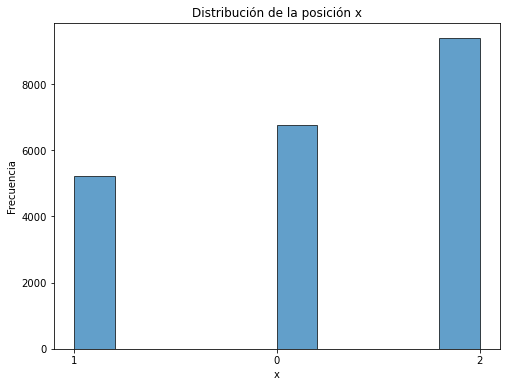

In [14]:
# Extraer la primera posición sin modificar el DataFrame
x_positions = df_train_mapa['etiqueta'].apply(lambda x: x[0])

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Crear el histograma
ax.hist(x_positions, bins=10, edgecolor='black', alpha=0.7)

# Agregar el título y las etiquetas de los ejes
ax.set_title('Distribución de la posición x')
ax.set_xlabel('x')
ax.set_ylabel('Frecuencia')

# Mostrar la figura
plt.show()

In [15]:
from sklearn.utils import class_weight

def aplicar_one_hot_balanceo(df,columa):
    # Crear un DataFrame con las columnas de one-hot encoding
    one_hot_df = pd.get_dummies(df[columa], prefix='label')

    # Unir el DataFrame original con el DataFrame de one-hot encoding
    df = pd.concat([df, one_hot_df], axis=1)

    # Balanceamos los pesos para el entrenamiento
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df[columa]),
        y=df[columa]
    )

    # Crear un diccionario de pesos para las clases
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    #Eliminamos la columna original
    df = df.drop(columa, axis=1)
    return df , class_weight_dict

In [16]:
df_train_mapa , pesos_train = aplicar_one_hot_balanceo(df_train_mapa,"etiqueta")
df_valid_mapa , pesos_valid = aplicar_one_hot_balanceo(df_valid_mapa,"etiqueta")
df_test_mapa , pesos_test= aplicar_one_hot_balanceo(df_test_mapa,"etiqueta")

In [17]:
ETIQUETAS = np.array(df_train_mapa.filter(like='label').columns.tolist())

In [18]:
from keras.utils import Sequence

class ImageDataGenerator(Sequence):
    def __init__(self, df , sequence_length ,image_height , image_width , batch_size, filtro, **kwargs):
        self.df = df
        self.image_sequence_length = sequence_length
        self.image_height = image_height
        self.image_width = image_width
        self.batch_size = batch_size
        self.POV = filtro
        super().__init__(**kwargs)  # Llamada al constructor de la clase base

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def cargar_todo(self,fin_df):
        batch_df = self.df.iloc[0:fin_df]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        #y_batch = batch_df[['izquieda', 'derecha', 'delante']].values
        y_batch = np.array(batch_df['mouse_final'].tolist())

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j])    # Obtener la ruta de la imagen
                imagen = Image.fromarray(np.array(imagen)).filter(ImageFilter.SHARPEN)  #Aplicamos Filtro SHARPEN
                imagen = np.array(imagen) / 255.0           # Normalizar la imagen
                imagen = imagen.astype("float32")  

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

    def __getitem__(self, index):
        inicio_lote = index * self.batch_size
        final_lote = (index + 1) * self.batch_size

        batch_df = self.df.iloc[inicio_lote:final_lote]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        # Obtener y_batch después del one-hot encoding
        #y_batch = batch_df[['izquieda', 'derecha','delante']].values
        #y_batch = np.array(batch_df['mouse_final'].tolist())

        # Filtrar las columnas que comienzan con 'label'
        y_batch = batch_df.filter(like='label').values

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j+2])    # Obtener la ruta de la imagen
                ancho, alto = imagen.size

                if self.POV == True :
                    imagen = imagen.rotate(2.5, expand=True)
                    # Recorta la imagen (izquierda, superior, derecha, inferior)
                    imagen = imagen.crop((5, 12, ancho - 35, alto-25))
                    imagen = ImageEnhance.Sharpness(imagen)
                    imagen = imagen.enhance(7)  # Aumento de contraste

                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

def comprobar_contenido(X_train , Y_train , num_video):

    fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 1 * 2))

    for i in range(5):
        axs[i].imshow(X_train[num_video][i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()
    print(Y_train[num_video])
    return Y_train[num_video]


class ImageDataGeneratorVAR(ImageDataGenerator):
    def __init__(self, df , sequence_length ,image_height , image_width , batch_size, filtro,autoencoder,encoder = None,**kwargs):
        self.autoencoder = autoencoder
        self.encoder_entrenado = encoder
        super().__init__(df, sequence_length, image_height, image_width, batch_size, filtro, **kwargs)

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def cargar_todo(self,fin_df):
        batch_df = self.df.iloc[0:fin_df]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        #y_batch = batch_df[['izquieda', 'derecha', 'delante']].values
        y_batch = np.array(batch_df['mouse_final'].tolist())

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j])    # Obtener la ruta de la imagen
                imagen = Image.fromarray(np.array(imagen)).filter(ImageFilter.SHARPEN)  #Aplicamos Filtro SHARPEN
                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

    def __getitem__(self, index):
        inicio_lote = index * self.batch_size
        final_lote = (index + 1) * self.batch_size

        batch_df = self.df.iloc[inicio_lote:final_lote]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes

        # Filtrar las columnas que comienzan con 'label'
        y_batch = batch_df.filter(like='label').values

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j+2])    # Obtener la ruta de la imagen
                ancho, alto = imagen.size

                if self.POV == True :
                    imagen = imagen.rotate(2.5, expand=True)
                    # Recorta la imagen (izquierda, superior, derecha, inferior)
                    imagen = imagen.crop((5, 12, ancho - 35, alto-25))
                    imagen = ImageEnhance.Sharpness(imagen)
                    imagen = imagen.enhance(7)  # Aumento de contraste

                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video
        
        #Para autoencoder
        if self.autoencoder == True:
            return X_batch, X_batch
        else : 
            return X_batch, y_batch

def comprobar_contenido(X_train , num_video):

    fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 1 * 2))

    for i in range(5):
        axs[i].imshow(X_train[num_video][i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

### Preparacion

In [19]:
def concatenar_imgs_individual(X_batch):
    batch_independiente = []
    for i in range(X_batch.shape[0]):
        batch_independiente.append(X_batch[i][4])
    return np.array(batch_independiente)

In [20]:
encoder_entrenado = None
autoencoder = False
# Generador Mapa
altura_img_mini = 188
anchura_img_mini = 260
batch_size = BATCH 

# Generadores para autoencoder
train_generator_Mapa = ImageDataGeneratorVAR(df_train_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True , autoencoder = autoencoder , encoder= encoder_entrenado)
test_generator_Mapa = ImageDataGeneratorVAR(df_test_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True, autoencoder = autoencoder, encoder= encoder_entrenado)
valid_generator_Mapa = ImageDataGeneratorVAR(df_valid_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True, autoencoder = autoencoder, encoder= encoder_entrenado)

4275


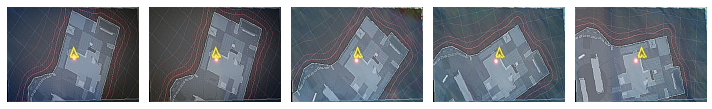

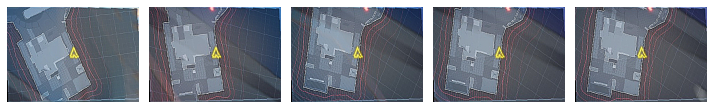

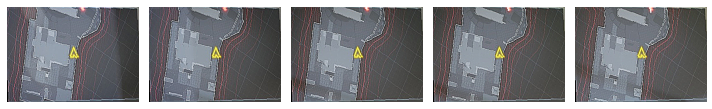

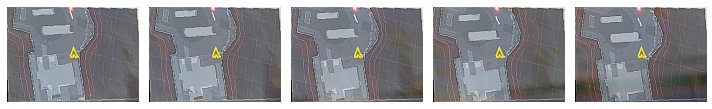

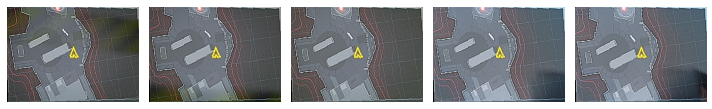

In [21]:
#Cantidad de batches en los que se divide el df
print(train_generator_Mapa.__len__())

#Comprobamos funcionamiento bach
X_batch, Y_batch = train_generator_Mapa.__getitem__(2)

for i in range(0,batch_size):  # 4 es el maximo de conjunto de imagenes del batch creado
    # Seleccionamos ver la posicion numero 0 del batch creado
    comprobar_contenido(X_batch ,i)

In [22]:
Y_batch[2]

array([0, 0, 1], dtype=uint8)

### Entrenamiento

In [31]:
class VAE(tf.keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)
        self.enc.summary()
        self.dec.summary()

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        mu, _ = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu)

    def decode(self, z):
        return self.dec(z)

    def compute_loss(self, x):
        x = tf.cast(x, tf.float32)  # Convertir a float32 para evitar conflictos
        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)
        p_z = ds.MultivariateNormalDiag(
          loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
          )
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x - x_recon), axis=0))

        return recon_loss, latent_loss

    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

In [32]:
from tensorflow.keras.regularizers import l2

BATCH_SIZE=BATCH
#Input imagen
height = 188
width = 260
channels = 3
DIMS = (height, width, channels)
#Espacio Latente
N_Z = 10
z_dims = (N_Z,)

encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z*2),
]
decoder = [
    tf.keras.layers.InputLayer(input_shape=z_dims),
    tf.keras.layers.Dense(52224, activation="relu", kernel_regularizer=l2(0.01)),
    tf.keras.layers.Reshape((12, 17, 256)),  # Reshape para la compatibilidad con convoluciones

    tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation="relu", kernel_regularizer=l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="relu", kernel_regularizer=l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same", activation="relu", kernel_regularizer=l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="same", activation="relu", kernel_regularizer=l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2DTranspose(3, (3, 3), padding="same", activation="sigmoid"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Cropping2D(((2, 2), (6, 6))),  # Recortar la imagen final
]

In [33]:
modelo = VAE(
    enc = encoder,
    dec = decoder,
    optimizer = tf.keras.optimizers.Adam(1e-3),
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 188, 260, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 94, 130, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 94, 130, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 47, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 47, 65, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 33, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 33, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 52224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │     1,044,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,432,916 (5.47 MB)

 Trainable params: 1,432,916 (5.47 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 52224)          │       574,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 12, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 24, 34, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 34, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 48, 68, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 68, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 48, 68, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 96, 136, 32)    │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 96, 136, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 96, 136, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 192, 272, 16)   │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 192, 272, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 192, 272, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 192, 272, 3)    │           435 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 192, 272, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 192, 272, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_1 (Cropping2D)       │ (None, 188, 260, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 967,791 (3.69 MB)

 Trainable params: 967,305 (3.69 MB)

 Non-trainable params: 486 (1.90 KB)

In [34]:
example_data, labels = train_generator_Mapa[0]
example_data = concatenar_imgs_individual(example_data)

In [35]:
example_data.shape

(5, 188, 260, 3)

In [36]:
# exampled data for plotting results
#example_data = next(iter(test_dataset))

def plot_reconstruction(model, example_data, nex=4, zm=2):

    example_data_reconstructed = model.reconstruct(example_data)
    samples = model.decode(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, example_data_reconstructed, samples],
            ["data", "data recon", "samples"],
        )
    ):
        for ex in range(nex):
            axs[axi, ex].matshow(
                dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)

    plt.show()

In [37]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['recon_loss', 'latent_loss'])

In [ ]:
n_epochs = 10
for epoch in range(n_epochs):
  #train
  for step in range(len(train_generator_Mapa)):
    imgs, labels = train_generator_Mapa[step]
    train_x = concatenar_imgs_individual(imgs)
    modelo.train(train_x)   #(512, 28, 28, 1)

  loss = []
  #test
  for step in range(len(test_generator_Mapa)):
    imgs, labels = test_generator_Mapa[step]
    test_X = concatenar_imgs_individual(imgs)
    loss.append(modelo.compute_loss(test_X))   #(512, 28, 28, 1)

  losses.loc[len(losses)] = np.mean(loss, axis=0)
  # plot results
  display.clear_output()
  print(
      "Epoch: {} | recon_loss: {} | latent_loss: {}".format(
          epoch, losses.recon_loss.values[-1], losses.latent_loss.values[-1]
      )
  )
  plot_reconstruction(modelo, example_data)

In [ ]:
# sample from grid
nx = ny =10
meshgrid = np.meshgrid(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T
x_grid = modelo.decode(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, 28,28, 1)
# fill canvas
canvas = np.zeros((nx*28, ny*28))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*28:xi*28+28, yi*28:yi*28+28] = x_grid[xi, yi,:,:,:].squeeze()
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(canvas, cmap=plt.cm.Greys)
ax.axis('off')